In [ ]:
!pip install lime tensorflow
!pip install transformers==2.1

LIBS

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for explainer
from lime import lime_text
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

from sklearn import model_selection, metrics

DATASET

DATASET FOR TRAINING

        Unnamed: 0  ...                cat
0           120583  ...           BUSINESS
1           156798  ...           BUSINESS
2           128793  ...  POLITICS & WORLDS
3            54173  ...               TECH
4            98514  ...              SPORT
...            ...  ...                ...
163851       74154  ...               TECH
163852       90101  ...               TECH
163853       13540  ...               TECH
163854      116560  ...  POLITICS & WORLDS
163855      108523  ...           BUSINESS

[163856 rows x 3 columns]


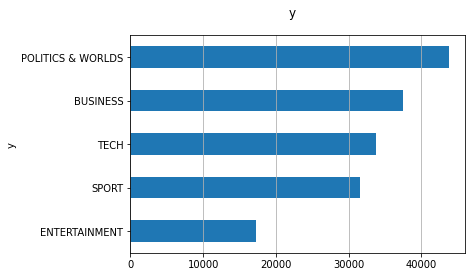

In [ ]:
dtf = pd.read_csv('/content/drive/My Drive/Dataset/final_dataset.csv')
dtf = dtf.sample(frac=1).reset_index(drop=True)
dtf = dtf.rename(columns={"cat":"y"})

fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12) 
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()



```
# This is formatted as code
```

DATAUTIL

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)
    return text
    

CREATING FEATURE MATRIX

In [ ]:
def create_feature_matrix(corpus):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
    maxlen = 150
    maxqnans = np.int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)
    feature_matrix = [np.asarray(idx, dtype='int32'), 
                      np.asarray(masks, dtype='int32'), 
                      np.asarray(segments, dtype='int32')]
    return feature_matrix

PREPROCESS

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.01)
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [ ]:
print('Raw text')
print(dtf['text'][4].split('.')[0])
print(dtf['text'][4].split('.')[1])
print(dtf['text'][4].split('.')[2])
print('Clean text')
print(dtf['text_clean'][4])

Raw text
This is a rotten time for moral victories
 Like it or not, the New York Giants received one Sunday
 While their playoff hopes took another hit when their rally 
Clean text
rotten time moral victory like new york giant received one sunday playoff hope took another hit rally


In [ ]:
X_train = create_feature_matrix(dtf_train['text_clean'])

100%|██████████| 231508/231508 [00:00<00:00, 10536986.65B/s]


In [ ]:
## inputs
idx = layers.Input((150), dtype="int32", name="input_idx")
masks = layers.Input((150), dtype="int32", name="input_masks")
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

100%|██████████| 363423424/363423424 [00:07<00:00, 50536854.45B/s]


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 150, 768),)  66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0

TRAIN

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])


In [ ]:
## train
training = model.fit(X_train, y_train, batch_size=64, epochs=30, shuffle=True, verbose=1, validation_split=0.3)
model.save('/content/drive/My Drive/Models/distilBert')

Epoch 1/30
1434/1434 [==============================] - 729s 508ms/step - loss: 0.4592 - accuracy: 0.8399 - val_loss: 0.3905 - val_accuracy: 0.8622
Epoch 2/30
1434/1434 [==============================] - 732s 510ms/step - loss: 0.4032 - accuracy: 0.8573 - val_loss: 0.3630 - val_accuracy: 0.8711
Epoch 3/30
1434/1434 [==============================] - 733s 511ms/step - loss: 0.3863 - accuracy: 0.8628 - val_loss: 0.3538 - val_accuracy: 0.8762
Epoch 4/30
1434/1434 [==============================] - 733s 511ms/step - loss: 0.3729 - accuracy: 0.8667 - val_loss: 0.3463 - val_accuracy: 0.8775
Epoch 5/30
1434/1434 [==============================] - 733s 511ms/step - loss: 0.3645 - accuracy: 0.8696 - val_loss: 0.3381 - val_accuracy: 0.8793
Epoch 6/30
1434/1434 [==============================] - 731s 510ms/step - loss: 0.3556 - accuracy: 0.8725 - val_loss: 0.3348 - val_accuracy: 0.8814
Epoch 7/30
1434/1434 [==============================] - 732s 510ms/step - loss: 0.3511 - accuracy: 0.8746 - val_

TEST

In [ ]:
X_test = create_feature_matrix(dtf_test['text_clean'])

[array([[  101,  4946,  3345, ...,     0,     0,     0],
        [  101,  9706,  2047, ...,     0,     0,     0],
        [  101, 18566, 26679, ...,     0,     0,     0],
        ...,
        [  101,  3782,  2600, ...,     0,     0,     0],
        [  101,  5675,  2028, ...,     0,     0,     0],
        [  101,  3725,  5742, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]], dtype=int32)]

In [ ]:
new_model = models.load_model('/content/drive/My Drive/Models/distilBert')
try:
    predicted_prob = new_model.predict(X_test, batch_size = 64)
except:
    predicted_prob = new_model.predict([np.asarray(X_test[0]),np.asarray(X_test[1])], batch_size = 64)

In [ ]:
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
dtf_pred = pd.DataFrame(predicted)

In [ ]:
text_sample = dtf_test['text']
expect = dtf_test['y']

In [ ]:
frame = {'text': text_sample.values, 'expectation': expect.values, 'prediction': dtf_pred[0].values }
d_t_f = pd.DataFrame(frame)

In [ ]:
d_t_f.to_csv('/content/drive/My Drive/BERT/result.csv')

In [ ]:
# bbcdtf = pd.read_csv('/content/drive/My Drive/Dataset/BBC/bbc.csv')
# bbcdtf = bbcdtf.sample(frac=1).reset_index(drop=True)
# bbcdtf.drop(['cat', 'Unnamed: 0'], axis = 1, inplace = True)
# new_model = models.load_model('/content/drive/My Drive/Models/distilBert50maxlen')

# predicted_prob = new_model.predict(create_feature_matrix(bbcdtf['text']), batch_size = 64)
# predicted = []
# i = 0
# while (i < len(predicted_prob)):
#     try:
#         result = {0: 'BUSINESS', 1: 'ENTERTAINMENT', 2: 'POLITICS & WORLDS', 3: 'SPORT', 4: 'TECH'}[np.argmax(predicted_prob[i])]
#         predicted.append(result)
#     except:
#         print(i)
#         predicted.append('UNKNOWN')
#     i = i + 1
# predicted = pd.DataFrame(predicted)
# frame = {'text': bbcdtf['text'], 'prediction': predicted[0].values }
# d_t_f = pd.DataFrame(frame)
# d_t_f.to_csv('/content/drive/My Drive/BERT/bbcresult.csv')

In [ ]:
new_model = models.load_model('/content/drive/My Drive/Models/distilBert)

In [ ]:
predicted_prob = new_model.predict(X_test, batch_size = 64)

In [ ]:
predicted = []
i = 0
while (i < len(predicted_prob)):
    try:
        result = {0: 'BUSINESS', 1: 'ENTERTAINMENT', 2: 'POLITICS & WORLDS', 3: 'SPORT', 4: 'TECH'}[np.argmax(predicted_prob[i])]
        predicted.append(result)
    except:
        print(i)
        predicted.append('UNKNOWN')
    i = i + 1
predicted = pd.DataFrame(predicted)

In [ ]:
frame = {'text': dtf_test['text'], 'prediction': predicted[0].values }
d_t_f = pd.DataFrame(frame)

In [ ]:
classes = np.unique(y_test)

In [ ]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values

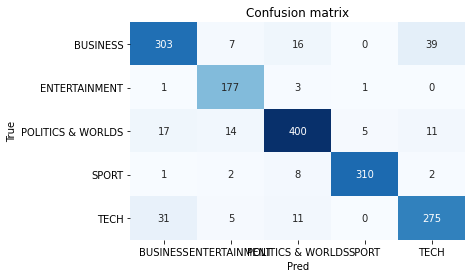

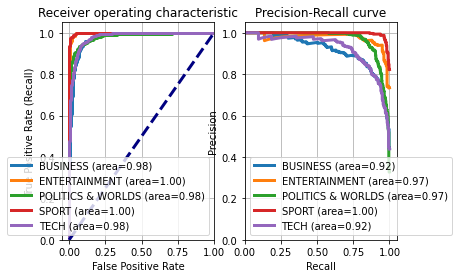

In [ ]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()